In [1]:
import torchvision.transforms as transforms
import torch
import yaml
from utils import *
import time
import os
import shutil
import torch.backends.cudnn as cudnn
from test_dataloader import get_loader_test
import pickle
import argparse
from PLIPmodel import Create_PLIP_Model
from tqdm import tqdm
import sys
import os
from zs_infer import Test_parse_args
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import glob
import re
from transformers import BertTokenizer
import matplotlib.pyplot as plt


In [2]:

# Add the path to the directory containing zs_infer.py to the system path
sys.path.append('/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/PLIP')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
args = Test_parse_args(notebook=True)
print(args)

def read_image(img_path):
    """Keep reading image until succeed.
    This can avoid IOError incurred by heavy IO process."""
    got_img = False
    if not osp.exists(img_path):
        raise IOError("{} does not exist...osp output: {}".format(img_path, osp.exists(img_path)))
    while not got_img:
        try:
            img = Image.open(img_path).convert('RGB')
            got_img = True
        except IOError:
            print("IOError incurred when reading '{}'. Will redo. Don't worry. Just chill.".format(img_path))
            pass
    return img

def val_collate_fn(batch):
    imgs, seg_imgs, pids, camids, viewids, img_paths = zip(*batch)
    viewids = torch.tensor(viewids, dtype=torch.int64)
    camids_batch = torch.tensor(camids, dtype=torch.int64)
    return torch.stack(imgs, dim=0), torch.stack(seg_imgs, dim=0), pids, camids, camids_batch, viewids, img_paths

class ImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256,128), interpolation=3),
                transforms.ToTensor(),
                transforms.Normalize((0.357, 0.323, 0.328),
                                    (0.252, 0.242, 0.239))
            ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_path, pid, camid, trackid = self.dataset[index]
        img = read_image(img_path)
        seg_img = img
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.Resize((352, 352)),
        ])

        if self.transform is not None:
            img = self.transform(img)
            seg_img = transform(seg_img)

        return img, seg_img, pid, camid, trackid, img_path #img_path.split('/')[-1]

def _process_dir(dir_path='/export/livia/home/vision/Rbhattacharya/work/data/data/market1501/Market-1501-v15.09.15/bounding_box_test', relabel=False):
    img_paths = glob.glob(osp.join(dir_path, '*.jpg'))
    pattern = re.compile(r'([-\d]+)_c(\d)')

    pid_container = set()
    for img_path in sorted(img_paths):
        pid, _ = map(int, pattern.search(img_path).groups())
        if pid == -1: continue  # junk images are just ignored
        pid_container.add(pid)
    pid2label = {pid: label for label, pid in enumerate(pid_container)}
    dataset = []
    for img_path in sorted(img_paths):
        pid, camid = map(int, pattern.search(img_path).groups())
        if pid == -1: continue  # junk images are just ignored
        assert 0 <= pid <= 1501  # pid == 0 means background
        assert 1 <= camid <= 6
        camid -= 1  # index starts from 0
        if relabel: pid = pid2label[pid]

        dataset.append((img_path, pid, camid, 0))
    return dataset

Namespace(model_path='checkpoints/PLIP_MRN50.pth.tar', image_path='data/CUHK-PEDES/imgs', test_path='data/CUHK-PEDES/CUHK-PEDES-test.json', plip_model='MResNet_BERT', img_backbone='ModifiedResNet', txt_backbone='bert-base-uncased', img_dim=768, text_dim=768, layers=[3, 4, 6, 3], heads=8, height=256, width=128, batch_size=128, num_workers=4, device='cuda:0', feature_size=768)


In [3]:
dataset = _process_dir()
Gdataset = ImageDataset(dataset)
Gloader = DataLoader(Gdataset, batch_size=1, shuffle=False, num_workers=1, collate_fn=val_collate_fn)

In [4]:
model = Create_PLIP_Model(args).to(device)
model_file = args.model_path
#breakpoint()
print(model_file)
#if os.path.isdir(model_file): continue
checkpoint = torch.load(model_file,map_location='cpu')

model.image_encoder.load_state_dict(checkpoint["ImgEncoder_state_dict"])
model.text_encoder.load_state_dict(checkpoint["TxtEncoder_state_dict"], strict=False)

TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(caption, tokenizer=TOKENIZER):
    result = tokenizer(caption, padding="max_length", max_length=64, truncation=True, return_tensors='pt')
    token, mask = result["input_ids"], result["attention_mask"]
    token, mask = token.squeeze(), mask.squeeze()
    return token, mask

checkpoints/PLIP_MRN50.pth.tar


In [5]:
#Encode gallery Market

model = model.eval()
gallery_features = []
gallery_pids = []
gallery_camids = []
imgpaths = []

with torch.no_grad():
    for batch in tqdm(Gloader):
        imgs, seg_imgs, pids, camids, camids_batch, viewids, img_paths = batch
        imgs = imgs.to(device)
        seg_imgs = seg_imgs.to(device)
        features = model.get_image_embeddings(imgs)
        gallery_features.append(features)
        gallery_pids.extend(pids)
        gallery_camids.extend(camids)
        imgpaths.extend(img_paths)
gallery_features = torch.cat(gallery_features, dim=0)
gallery_pids = torch.tensor(gallery_pids, dtype=torch.int64)
gallery_camids = torch.tensor(gallery_camids, dtype=torch.int64)

100%|██████████| 15913/15913 [06:12<00:00, 42.75it/s] 


In [6]:
# encode query text prompt:
#query_text = "A man with black hair is wearing a white shirt with gray shorts. He is also wearing white shoes and carrying a white bag."
#query_text = "A woman with long black hair is wearing a blue shirt and grey trousers. She is walking in front of a park and is wearing white shoes."
#query_text = "A man with black hair is wearing a white shirt with gray shorts. He is also wearing white shoes."
#query_text = "A man with black hair is wearing a white shirt with gray shorts. He is also wearing white shoes and carrying a white bag."

query_text = "A woman wearing a light-coloured dress."

tokens, mask = tokenize(query_text)
with torch.no_grad():
    # query_feature = model.get_text_global_embedding(tokens.unsqueeze(0).to(device), mask.unsqueeze(0).to(device))
    query_feature, query_part_feature = model.text_encoder(tokens.unsqueeze(0).to(device), mask.unsqueeze(0).to(device))
    query_feature = query_feature / (query_feature.norm(dim=1, keepdim=True) + 1e-12)
    gallery_features = gallery_features / (gallery_features.norm(dim=1, keepdim=True) + 1e-12)
    query_feature = query_feature.view(-1, 1)
    score = torch.mm(gallery_features, query_feature) # normalized inner product -> cosine similarity based matching
score = score.squeeze(1).detach().cpu()
score = score.numpy()
index = np.argsort(score)
index = index[::-1]

0.5839967 -0.32413957
/export/livia/home/vision/Rbhattacharya/work/data/data/market1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s6_014996_04.jpg
/export/livia/home/vision/Rbhattacharya/work/data/data/market1501/Market-1501-v15.09.15/bounding_box_test/0000_c6s2_115968_03.jpg
/export/livia/home/vision/Rbhattacharya/work/data/data/market1501/Market-1501-v15.09.15/bounding_box_test/0000_c6s3_016817_07.jpg
/export/livia/home/vision/Rbhattacharya/work/data/data/market1501/Market-1501-v15.09.15/bounding_box_test/0000_c6s2_102893_09.jpg
/export/livia/home/vision/Rbhattacharya/work/data/data/market1501/Market-1501-v15.09.15/bounding_box_test/0000_c3s3_033153_05.jpg
/export/livia/home/vision/Rbhattacharya/work/data/data/market1501/Market-1501-v15.09.15/bounding_box_test/0000_c3s1_079992_01.jpg
/export/livia/home/vision/Rbhattacharya/work/data/data/market1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s5_006361_08.jpg
/export/livia/home/vision/Rbhattacharya/work/data/data/market1501/Ma

[Text(0, -15, 'PID: 0; \n CID: 0; \n D: 0.58'),
 Text(0, -15, 'PID: 0; \n CID: 5; \n D: 0.57'),
 Text(0, -15, 'PID: 0; \n CID: 5; \n D: 0.56'),
 Text(0, -15, 'PID: 0; \n CID: 5; \n D: 0.55'),
 Text(0, -15, 'PID: 0; \n CID: 2; \n D: 0.55'),
 Text(0, -15, 'PID: 0; \n CID: 2; \n D: 0.54'),
 Text(0, -15, 'PID: 0; \n CID: 0; \n D: 0.54'),
 Text(0, -15, 'PID: 0; \n CID: 2; \n D: 0.54'),
 Text(0, -15, 'PID: 0; \n CID: 0; \n D: 0.54'),
 Text(0, -15, 'PID: 0; \n CID: 1; \n D: 0.54')]

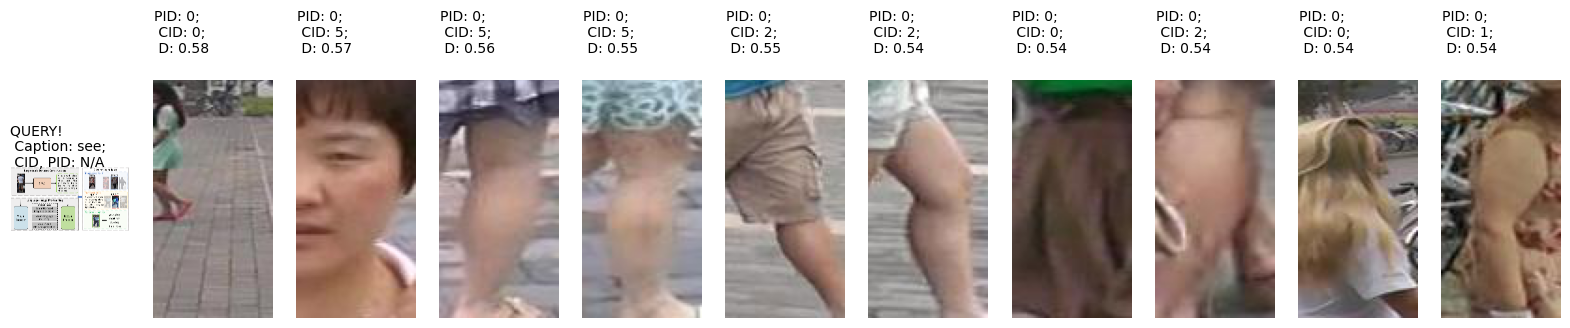

In [7]:
# Choose query index and top-k:
idx, k = 134, 10
D = score
D_ids = index
distances = D[index]
print(distances[0], distances[-1])

gallery_paths = np.array(imgpaths)[D_ids]
query_path = imgpaths[idx]

_, ax = plt.subplots(1, 1+k, figsize=(20, k))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(read_image("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/PLIP/assets/abstract.png"))
ax[0].text(0, -15, f"QUERY! \n Caption: see; \n CID, PID: N/A")
for i in range(k): print(gallery_paths[i])
[ax[i+1].imshow(read_image(gallery_paths[i])) for i in range(k)]

[ax[i+1].text(0, -15, f"PID: {gallery_pids[D_ids[i]]}; \n CID: {gallery_camids[D_ids[i]]}; \n D: {D[D_ids[i]]:.2f}") for i in range(k)]

In [8]:
print(D.min(), D.max())

-0.3268341 0.58089906


torch.Size([768, 1])
torch.Size([1, 64, 768])
torch.Size([1, 64, 768]) torch.Size([768, 1])
torch.Size([64, 1])
tensor(0.0433, device='cuda:1') tensor(0.0125, device='cuda:1')


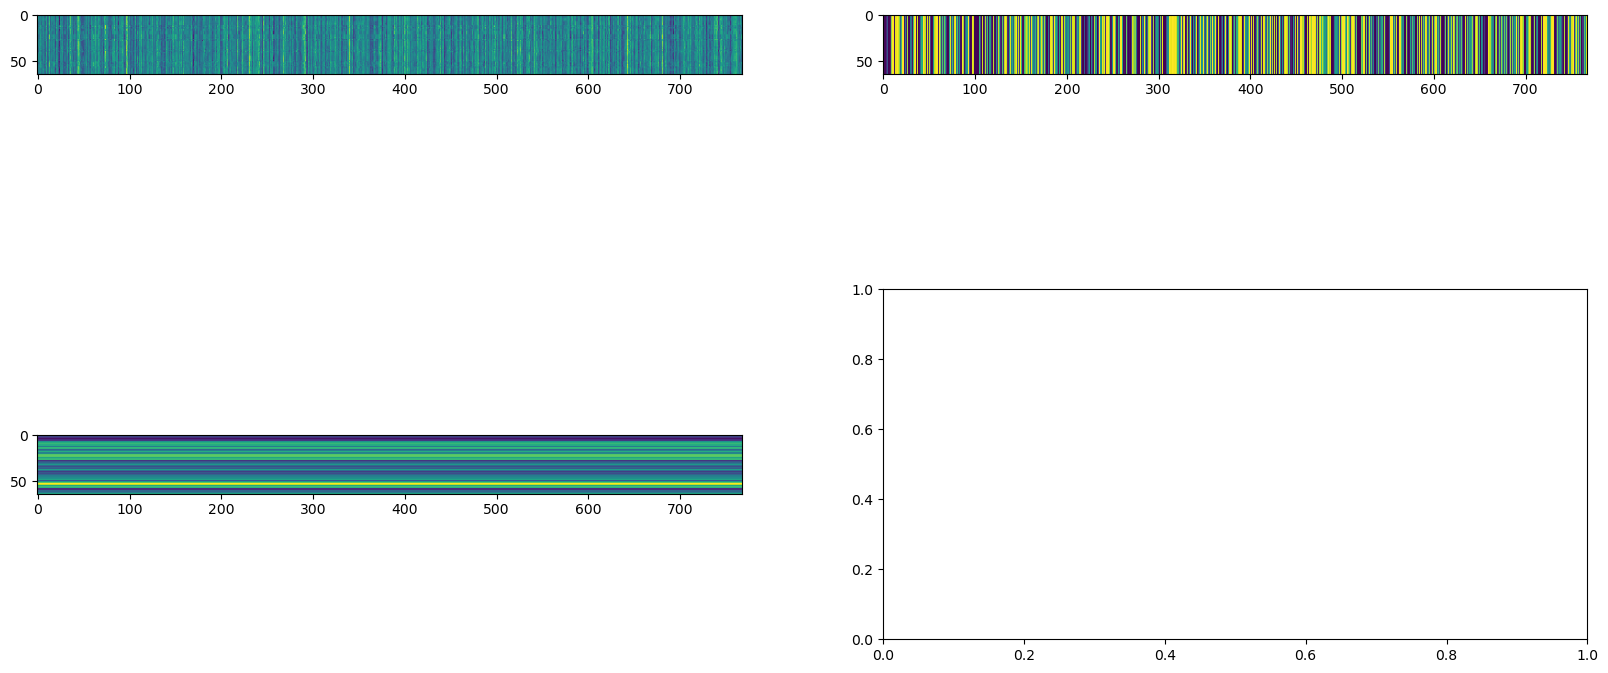

In [20]:
print(query_feature.shape)
print(query_part_feature.shape)

qpf = query_part_feature / (query_part_feature.norm(dim=2, keepdim=True) + 1e-12)
print(qpf.shape, query_feature.shape)

part_text_agreement_score = torch.mm(qpf[0], query_feature)
print(part_text_agreement_score.shape)
print(part_text_agreement_score.mean(), part_text_agreement_score.std())
_, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0][0].imshow(qpf[0].detach().cpu().numpy())
#plt.clf()
ax[0][1].imshow(query_feature.reshape(1, -1).repeat(64, 1).detach().cpu().numpy())
ax[1][0].imshow(part_text_agreement_score.repeat(1,768).detach().cpu().numpy())

In [14]:
print(query_feature.shape)
print(gallery_pids)

torch.Size([768, 1])
tensor([   0,    0,    0,  ..., 1501, 1501, 1501])
